In [15]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
METRICS_DIR = "../processing/disease_detection/metrics"

In [3]:
def drop_invariant(df):
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df = df.drop(cols_to_drop, axis=1)
    return df, cols_to_drop

In [4]:
dfs = {}
df = pd.DataFrame()
cols = set()
for file in os.listdir(METRICS_DIR):
    if file.startswith("final") or os.path.isdir(os.path.join(METRICS_DIR, file)):
        continue
    name = file.split("_")[0]
    single_df = pd.read_csv(os.path.join(METRICS_DIR, file))
    single_df, _ = drop_invariant(single_df)
    recall_col = [col for col in single_df.columns if col.startswith("recall")][0]
    auc_col = [col for col in single_df.columns if col.startswith("auc")][0]
    single_df = single_df.rename(columns={auc_col: "auc", recall_col: "recall"})
    cols.update(single_df.columns)
    dfs[name] = single_df

In [5]:
cols = cols - set(["step", "epoch"])
print(cols)

{'auc', 'binary_accuracy', 'recall', 'loss'}


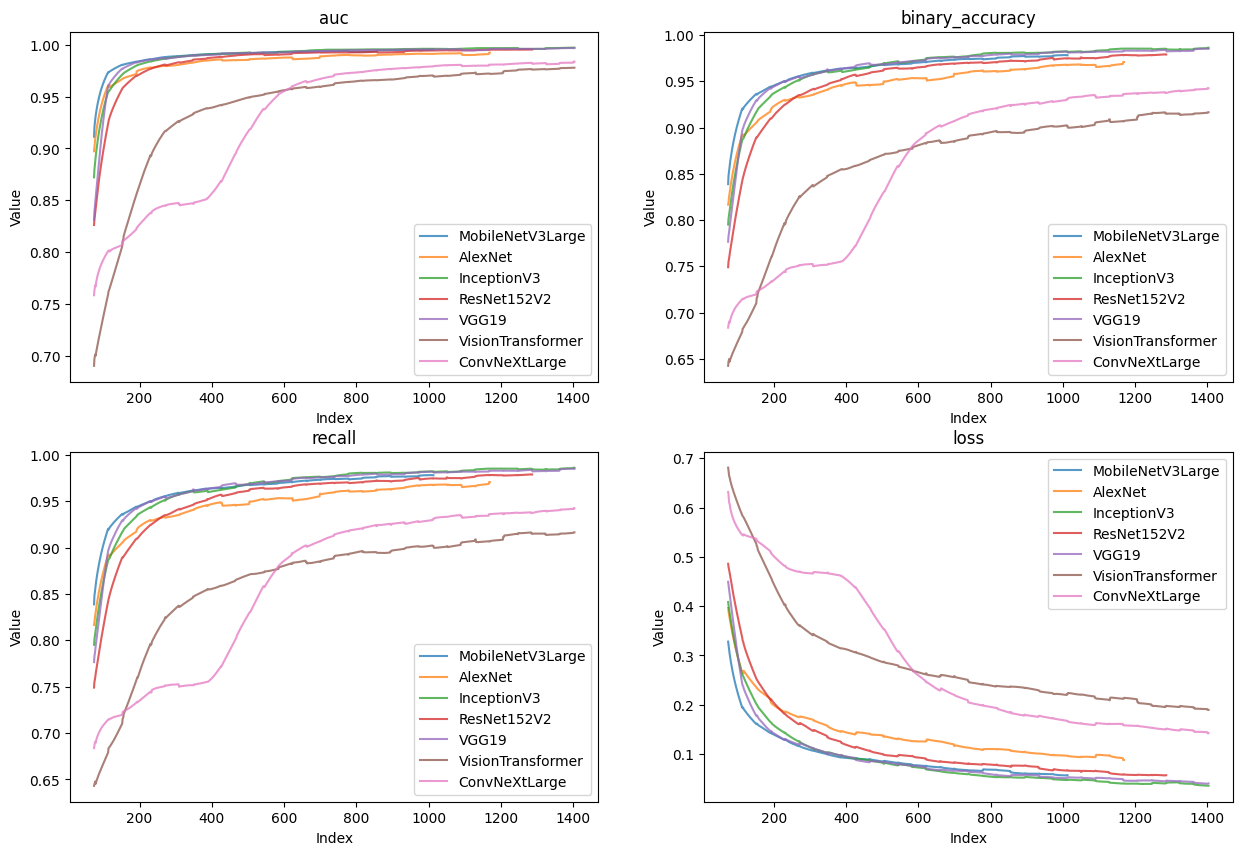

In [6]:
n_cols = len(cols)
n_rows = (n_cols + 1) // 2

window_size = 75

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(cols):
    for name, df in dfs.items():
        if name == "LeNet":
            continue
        axes[i].plot(df[col].rolling(window=window_size).mean(), label=name, alpha=.75)
#        axes[i].plot(df[col], linestyle=(0, (1, 5)), label=name, alpha=.4)
        axes[i].set_title(col)
        axes[i].set_xlabel('Index')
        axes[i].set_ylabel('Value')
        axes[i].legend()

In [20]:
dfs['LeNet']['loss'] = dfs['LeNet'].loss.map(lambda x: np.nan if x > 2 else x)

In [21]:
for name, df in dfs.items():
    for col in cols:
        print(name, col, df[col].min(), df[col].max())

LeNet auc 0.625 0.875
LeNet binary_accuracy 0.625 0.875
LeNet recall 0.625 0.875
LeNet loss 0.4808734357357025 0.6303271651268005
MobileNetV3Large auc 0.296875 1.0
MobileNetV3Large binary_accuracy 0.25 1.0
MobileNetV3Large recall 0.25 1.0
MobileNetV3Large loss 0.0023935106582939 0.6891107559204102
AlexNet auc 0.65234375 1.0
AlexNet binary_accuracy 0.6132425665855408 1.0
AlexNet recall 0.6132425665855408 1.0
AlexNet loss 0.0232298746705055 0.7521737813949585
InceptionV3 auc 0.40625 1.0
InceptionV3 binary_accuracy 0.4375 1.0
InceptionV3 recall 0.4375 1.0
InceptionV3 loss 0.0011235347483307 0.7573543190956116
ResNet152V2 auc 0.53515625 1.0
ResNet152V2 binary_accuracy 0.375 1.0
ResNet152V2 recall 0.375 1.0
ResNet152V2 loss 0.0012580829206854 0.7886614799499512
VGG19 auc 0.369140625 1.0
VGG19 binary_accuracy 0.4375 1.0
VGG19 recall 0.4375 1.0
VGG19 loss 0.0014276208821684 0.707890510559082
VisionTransformer auc 0.255859375 1.0
VisionTransformer binary_accuracy 0.34375 1.0
VisionTransformer 

In [30]:
final_dfs = {}
final_cols = set()
for file in os.listdir(METRICS_DIR):
    if not file.startswith("final"):
        continue
    name = file.split("_")[1]
    df = pd.read_csv(os.path.join(METRICS_DIR, file), index_col="Unnamed: 0")
    df = df.rename(lambda name: re.sub(r'_\d', '', name), axis='columns')
    final_cols.update(df.columns)
    final_dfs[name] = df

In [35]:
final_cols.remove('binary_accuracy')
final_cols.remove('val_binary_accuracy')

In [36]:
final_cols

['auc', 'loss', 'recall', 'val_auc', 'val_loss', 'val_recall']

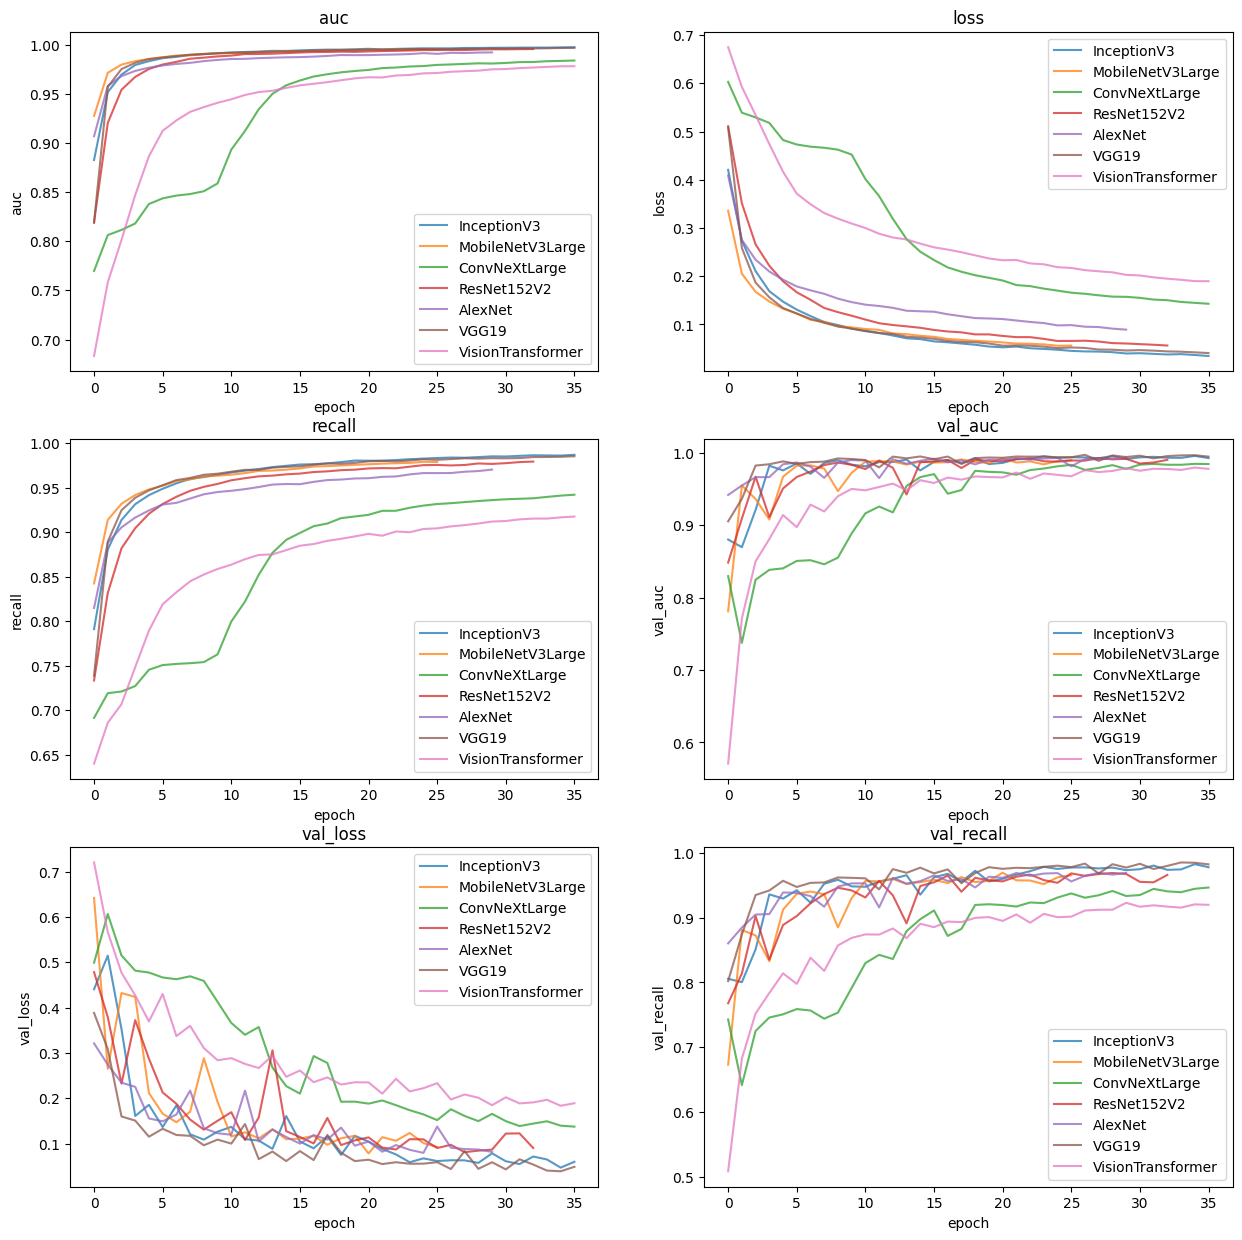

In [37]:
n_cols = len(final_cols)
n_rows = (n_cols + 1) // 2

window_size = 75

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))
axes = axes.flatten()

final_cols = sorted(final_cols)

for i, col in enumerate(final_cols):
    for name, df in final_dfs.items():
        if name == 'LeNet':
            continue
        line1, = axes[i].plot(df[col], label=name, alpha=.75)
        line2 = axes[i].plot(df[col].rolling(window=5).mean(),
                             linestyle=(0, (3, 3)), 
                             color=line1.get_color(), 
                             label='', 
                             alpha=0)
        axes[i].set_title(col)
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(col)
        axes[i].legend()